In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import  classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler

In [2]:
# Load pre-processed data
Poore_BLCA = pd.read_csv("Poore_BLCA", index_col=0)
Poore_BLCA

,g__Cobetia,g__Ammonifex,g__Owenweeksia,g__Haloplasma,g__Desulfosarcina,g__Asaia,g__Parvibaculum,g__Neosynechococcus,g__Zymomonas,g__Kutzneria,...,portion_weight,aliquot_concentration,analyte_A260A280Ratio,analyte_amount,analyte_type_label,radiation_therapy_code_label,radiation_therapy_site_label,radiation_therapy_type_label,year_of_diagnosis,vital_status_label
sample_id1,,,,,,,,,,,,,,,,,,,,,
s2803,1.920406,2.672018,2.367002,0.940031,1.232461,2.002862,1.850657,2.367745,0.100389,2.039194,...,30.0,0.17,1.90,30.43,RNA,NaN,NaN,NaN,2013.0,Alive
s2818,0.575837,2.554444,2.291717,2.598751,1.194319,2.225309,0.947783,2.423590,-0.478696,0.205046,...,30.0,0.17,1.88,57.79,RNA,NaN,NaN,NaN,2012.0,Dead
s2739,2.371029,3.318483,2.886261,2.828579,1.511368,2.651312,2.581111,2.998545,1.055463,1.974587,...,2.0,0.17,NaN,40.03,DNA,NaN,NaN,NaN,2011.0,Alive
s2683,-1.297436,3.088465,2.418900,-0.167309,1.477646,2.265682,1.883929,2.571443,-0.302522,1.642937,...,20.0,0.08,NaN,55.07,DNA,8ABD32E6-50C9-44EB-BA59-4572AA05C26C,Primary Tumor Field,External,2011.0,Alive
s2740,2.101283,3.048737,2.616515,1.821867,1.013353,2.381566,2.311365,2.728799,0.785717,1.052764,...,2.0,0.15,NaN,37.23,DNA,NaN,NaN,NaN,2011.0,Alive
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
s3399,1.629153,2.532004,2.086196,0.768015,1.767636,1.810276,3.350909,2.171045,-0.087753,1.846224,...,30.0,0.18,1.86,86.39,RNA,NaN,NaN,NaN,2013.0,Alive
s3397,1.659999,2.644176,2.185795,0.942269,1.843089,1.726946,1.860152,2.282646,0.028421,1.191240,...,30.0,0.17,1.83,21.29,RNA,NaN,NaN,NaN,2011.0,Alive
s3402,2.391737,3.294074,2.869479,1.585118,0.715287,2.446944,2.530973,3.036099,2.690550,0.821405,...,30.0,0.17,1.89,42.53,RNA,NaN,NaN,NaN,2007.0,Dead


In [3]:
class_counts = Poore_BLCA['sample_type'].value_counts()
print(class_counts)

sample_type
Primary Tumor           557
Blood Derived Normal    124
Solid Tissue Normal      48
Name: count, dtype: int64


In [4]:
# Prepare features and target variable
X = Poore_BLCA.drop(['gdc_file_uuid', 'filename', 'age_at_diagnosis', 'aliquot_uuid',
       'case_uuid', 'days_to_death', 'disease_type', 'ethnicity',
       'experimental_strategy', 'gender', 'investigation', 'platform',
       'primary_site', 'race', 'reference_genome', 'sample_type',
       'sample_uuid', 'vital_status', 'tissue_source_site_label',
       'data_submitting_center_label', 'country_of_sample_procurement',
       'histological_diagnosis_label', 'pathologic_t_label',
       'pathologic_n_label', 'pathologic_stage_label', 'icd03_histology_label',
       'icd03_histology_site', 'icd10', 'portion_is_ffpe',
       'new_tumor_event_after_initial_trtmt',
       'primary_therapy_outcome_success_label', 'portion_weight',
       'aliquot_concentration', 'analyte_A260A280Ratio', 'analyte_amount',
       'analyte_type_label', 'radiation_therapy_code_label',
       'radiation_therapy_site_label', 'radiation_therapy_type_label',
       'year_of_diagnosis', 'vital_status_label'], axis=1)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled
y = Poore_BLCA['sample_type']
print("Unique values of y:", np.unique(y))
le = LabelEncoder()
y = le.fit_transform(y)
y
print("Unique values of y:", np.unique(y))

Unique values of y: ['Blood Derived Normal' 'Primary Tumor' 'Solid Tissue Normal']
Unique values of y: [0 1 2]


In [5]:
# Oversampling to ensure class balance
oversampler = RandomOverSampler(sampling_strategy='not majority', random_state=42)
X_scaled, y = oversampler.fit_resample(X_scaled,y)
print(X_scaled.shape)
print(y.shape)

(1671, 1170)
(1671,)


In [6]:
# Feature selection
from sklearn.feature_selection import SelectFromModel
from sklearn.svm import LinearSVC

random_seed = 42
lsvc = LinearSVC(C = 0.1, penalty="l1", dual=False).fit(X_scaled, y)
model = SelectFromModel(lsvc, prefit=True)
X_new = model.transform(X_scaled)

X_new.shape

c:\Anaconda\Lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


(1671, 513)

Best Parameters: {'alpha': 0.1, 'eta': 0.01, 'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 100}
Best Score: 0.9238545908073805
Test Set Accuracy: 0.9621513944223108


<Figure size 800x600 with 0 Axes>

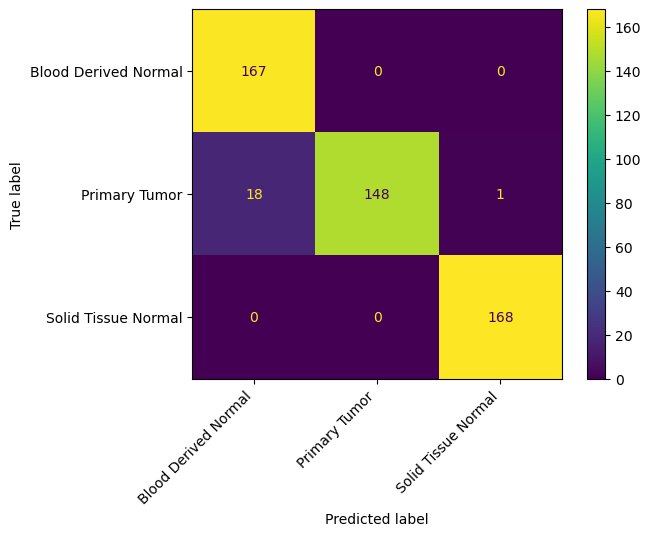

                      precision    recall  f1-score   support

Blood Derived Normal       0.90      1.00      0.95       167
       Primary Tumor       1.00      0.89      0.94       167
 Solid Tissue Normal       0.99      1.00      1.00       168

            accuracy                           0.96       502
           macro avg       0.97      0.96      0.96       502
        weighted avg       0.97      0.96      0.96       502



In [7]:
# Split the resampled data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.3, shuffle=True, random_state=42, stratify=y)

# Define parameters for XGBoost model
params = {
    'learning_rate':[0.01, 0.1],
    'max_depth': [3, 6, 9],
    'eta': [0.01, 0.1],
    #'lambda': [0.1, 1]
    'alpha': [0.01, 0.1], # Include L1 regularization
    'n_estimators': [50, 100]
}

# Initialize XGBoost classifier
xgb_model = xgb.XGBClassifier(objective='multi:softmax', num_class=3, eval_metric='mlogloss', seed=42)

# Perform Grid Search
grid_search = GridSearchCV(estimator=xgb_model, param_grid=params, scoring='accuracy', cv=5)
grid_search.fit(X_train, y_train)

# Get the best parameters and the best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best Parameters:", best_params)
print("Best Score:", best_score)

# Evaluate the model on the test set
test_score = grid_search.best_estimator_.score(X_test, y_test)
print("Test Set Accuracy:", test_score)

y_pred = grid_search.best_estimator_.predict(X_test)

# Calculate and display confusion matrix
cm = confusion_matrix(y_test, y_pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Blood Derived Normal', 'Primary Tumor', 'Solid Tissue Normal'])
plt.figure(figsize=(8, 6))
cm_display.plot()
plt.xticks(rotation=45, ha='right')
plt.show()

# Calculate precision, recall, and F1-score
report = classification_report(y_test, y_pred, target_names=['Blood Derived Normal', 'Primary Tumor', 'Solid Tissue Normal'])
print(report)


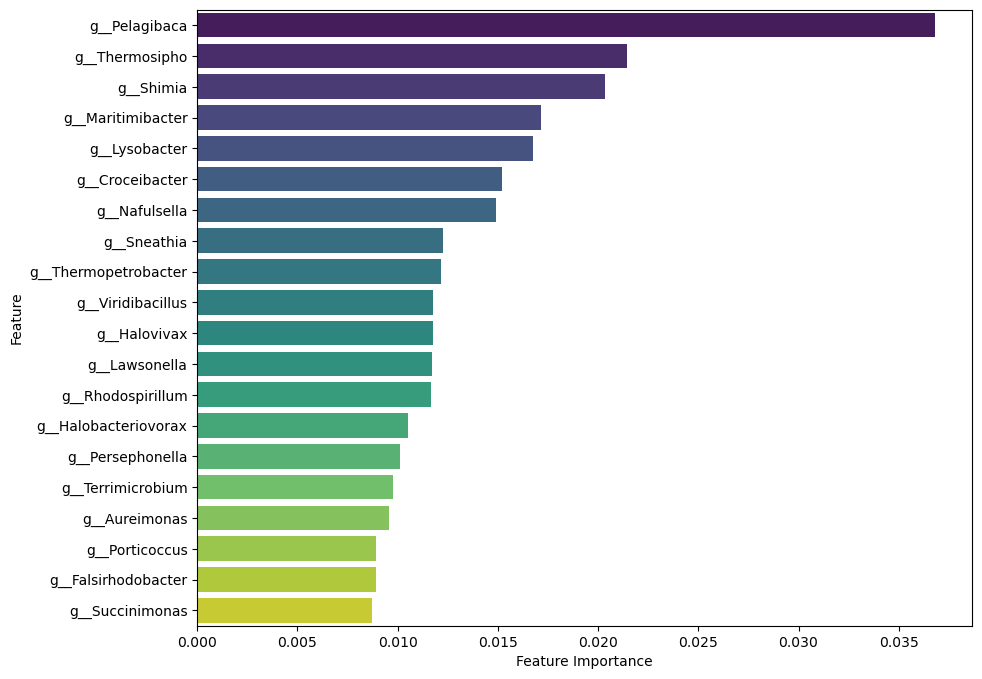

In [8]:
# Train XGBoost model with best parameters for calculating feature importances
best_xgb_model = xgb.XGBClassifier(objective='multi:softmax', num_class=3, eval_metric='mlogloss', **best_params)
best_xgb_model.fit(X_train, y_train)

feature_importances = best_xgb_model.feature_importances_
top_20_indices = feature_importances.argsort()[::-1][:20]
feature_names = X.columns

plt.figure(figsize=(10, 8))
sns.barplot(x=feature_importances[top_20_indices], y=feature_names[top_20_indices], palette="viridis")
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.show()

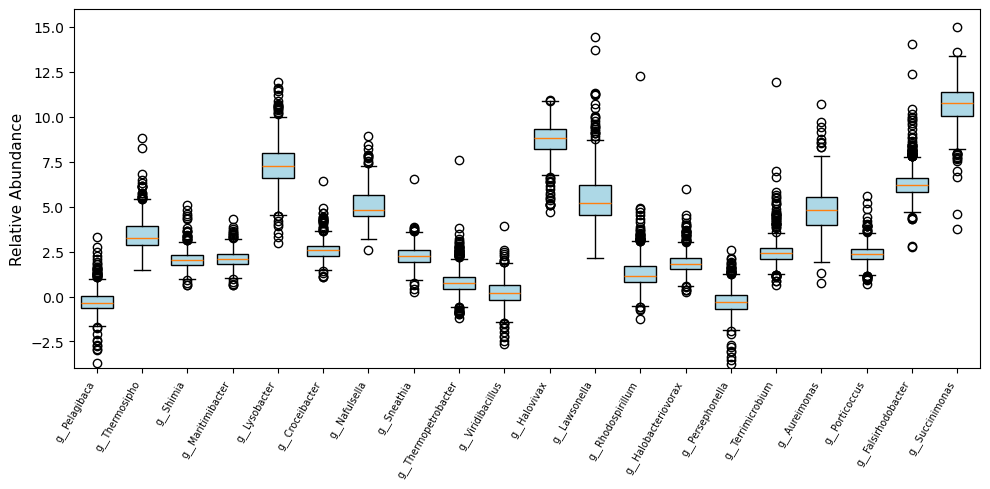

In [9]:
# Box plot for visualizing bacterial relative abundance of 10 most important bacteria

data = {}
top_20_feature_names = feature_names[top_20_indices]
#abundance_scaled = np.log2(X)

for column_name in top_20_feature_names:
    data[column_name] = X[column_name]

plt.figure(figsize=(10, 5))
plt.boxplot(data.values(), widths=0.7, patch_artist=True, 
            boxprops=dict(facecolor='lightblue'), whiskerprops=dict(color='black'))

plt.ylim(-4, 16)
plt.ylabel('Relative Abundance', fontsize=11)
plt.xticks(range(1, len(data) + 1), data.keys(), rotation=60, ha='right', fontsize=7)
plt.tight_layout()  
plt.show()